# Workflow to Validate NISAR L2 Transient Displacement Requirements

**Original code authored by:** NISAR Science Team Members and Affiliates  

*May 13, 2022*

*NISAR Solid Earth Team*

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Define CalVal Site 

In [ ]:
# Parameters for papermill

### Choose a site from the 'sites' dictionary found 2 cells down
## If your CentralValleyD144 area is not defined, add a new dictionary entry as appropriate and provide a unique site keyname
site = 'CentralValleyD144'

In [ ]:
# injected parameters

### Choose a site from the 'sites' dictionary found 2 cells down
## If your study area is not defined, add a new dictionary entry as appropriate and provide a unique site keyname
site='CentralValleyD144'

In [ ]:
# specify GNSS source for validation
from mintpy.objects import gnss
gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

# Set mask file
maskFile = 'maskConnComp.h5' # maskSpatialCoh.h5 maskTempCoh.h5 maskConnComp.h5 waterMask.h5 (maskConnComp.h5 is very conservative)

# Define spatial coherence threshold (necessary to reject poor quality, long temporal baseline pairs)
minCoherence_parm = '0.4'

## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#transient_prep_a)

[**Prep B. Data Staging**](#transient_prep_b)

[**1. Generate Interferogram Stack**](#transient_gen_ifg)
- [1.1.  Crop Interferograms](#transient_crop_ifg)

[**2. Optional Corrections**](#transient_opt_correction)
- [2.1. Solid Earth Tides Correction](#transient_solid_earth)
- [2.2. Tropospheric Delay Correction](#transient_tropo_corr)
- [2.3. Topographic Residual Correction ](#transient_tropo_res_corr)

[**3. Make GNSS LOS Measurements**](#transient_gnss_los)
- [3.1. Find Collocated GNSS Stations](#transient_co_gnss)  
- [3.2. Make GNSS LOS Measurements](#transient_gnss_los2) 
- [3.3. Make GNSS and InSAR Relative Displacements](#transient_gnss_insar)

[**4. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#transient_validation1)
- [4.1. Pair up GNSS stations and make measurement residuals](#transient_pair1)
- [4.2. Validate the requirement based on binned measurement residuals](#transient_bin1)
- [4.3. Result visulazation](#transient_result1)
- [4.3. Conclusion](#transient_conclusion1)

[**5. NISAR Validation Approach 2: Noise Level Validation**](#transient_validation2)
- [5.1. Randomly sample pixels and pair them up](#transient_pair2)
- [5.2. Validate the requirement based on binned measurement residuals](#transient_bin2)
- [5.3. Result visulazation](#transient_result2)
- [5.3. Conclusion](#transient_conclusion2)

[**6. Appendix: GNSS Position Plots**](#transient_appendix)

<hr/>

<a id='transient_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [ ]:
# load packages
import concurrent.futures
import copy
import os
import random
import time
from datetime import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import pyproj
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mintpy.objects import gnss
from mintpy.utils import readfile, utils as ut, utils0 as ut0, writefile

from solid_utils.sampling import load_geo, samp_pair

In [ ]:
################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

print("Work directory:", work_dir)
work_dir.mkdir(parents=True, exist_ok=True)
# Change to Workdir   
os.chdir(work_dir)

mintpy_dir = work_dir/'MintPy' 
mintpy_dir.mkdir(parents=True, exist_ok=True)
print("   MintPy  dir:", mintpy_dir)
############################################################################
### List of CalVal Sites:
'''
Set NISAR calval sites:
    CentralValleyD144  : Central Valley
    OklahomaA107       : Oklahoma
    PuertoRicoD98      : Puerto Rico (Earthquake M6.4 on 20200107) - Descending track 
    PuertoRicoA135     : Puerto Rico (Earthquake M6.4 on 20200107 & large aftershock on 20200703) - Ascending track
    RidgecrestD71      : Ridgecrest  (Earthquake M7.2 on 20190705) - Descending track
    RidgecrestA64      : Ridgecrest  (Earthquake M7.2 on 20190705) - Ascending track

ARIA & MintPy parameters:
    calval_location : name
    download_region : download box in S,N,W,E format
    analysis_region : analysis box in S,N,W,E format (must be within download_region)
    download_start_date : download start date as YYYMMDD  
    download_end_date   : download end date as YYYMMDD
    earthquakeDate :  arbitrary date for testing with the central_valley dataset
    sentinel_track : sentinel track to download
    gps_ref_site_name : Name of the GPS site for InSAR re-referencing
    tempBaseMax' : maximum number of days, 'don't use interferograms longer than this value 
    ifgExcludeList : default is not to exclude any interferograms
    maskWater' :  interior locations don't need to mask water
'''
sites = {
    ##########  CENTRAL VALLEY ##############
    'CentralValleyD144' : {'calval_location' : 'Central_Valley',
            'download_region' : '"36.18 36.26 -119.91 -119.77"', # download box in S,N,W,E format
            'analysis_region' : '"35.77 36.75 -120.61 -118.06"', # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20180101',
            'download_end_date' : '20190101',
            'earthquakeDate' : '20180412',                       # arbitrary date for testing with the central_valley dataset
            'sentinel_track' : '144',
            'gps_ref_site_name' : 'LAND',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},                       # reference site for this area
    ##########  CENTRAL VALLEY ##############
    'HawaiiA124' : {'calval_location' : 'Hawaii',
            'download_region' : '"19.22 19.70 -155.73 -155.33"', # download box in S,N,W,E format
            'analysis_region' : '"19.22 19.70 -155.73 -155.33"', # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20180101',
            'download_end_date' : '20190101',
            'earthquakeDate' : '20180412',                       # arbitrary date for testing with the central_valley dataset
            'sentinel_track' : '124',
            'gps_ref_site_name' : 'YEEP',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},                       # reference site for this area
    ##########  OKLAHOMA ##############
    'OklahomaA107' : {'calval_location' : 'Oklahoma',
            'download_region' : '"31.7 37.4 -103.3 -93.5"',      # download box in S,N,W,E format
            'analysis_region' : '"35.25 36.5 -100.5 -98.5"',     # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20210101',
            'download_end_date' : '20210801',
            'earthquakeDate' : '20210328',                       # arbitrary date for testing with the Oklahoma dataset
            'sentinel_track' : '107',
            'gps_ref_site_name' : 'OKCL',
            'tempBaseMax' : 'auto',
            'ifgExcludeList' : 'auto',
            'maskWater' : False},
    ##########  PUERTO RICO ##############
    'PuertoRicoD98' : {'calval_location' : 'PuertoRicoDesc',
            'download_region' : '"17.5 18.9 -67.5 -66.0"',       # download box in S,N,W,E format
            'analysis_region' : '"17.9 18.5 -67.3 -66.2"',       # analysis box in S,N,W,E format (must be within download_region)
            'download_start_date' : '20190701',
            'download_end_date' : '20200930',
            'earthquakeDate' : '20200107',                       # date of M6.4 quake
            'sentinel_track' : '98',                             # descending track
            'gps_ref_site_name' : 'PRLT',
            'tempBaseMax' : 24,                                  # don't use interferograms longer than 24 days
            'ifgExcludeList' : 'auto', 
            'maskWater' : True},                                 # need to mask ocean around Puerto Rico island
    'PuertoRicoA135' : {'calval_location' : 'PuertoRicoAsc',
             'download_region' : '"17.5 18.9 -67.5 -66.0"',      # download box in S,N,W,E format
             'analysis_region' : '"17.9 18.5 -67.3 -66.2"',      # analysis box in S,N,W,E format (must be within download_region)
             'download_start_date' : '20190701',
             'download_end_date' : '20200930',
             'earthquakeDate' : '20200107',                      # date of M6.4 quake
             'earthquakeDate2' : '20200703',                     # date of large aftershock
             'sentinel_track' : '135',                           # ascending track
             'gps_ref_site_name' : 'PRLT',
             'tempBaseMax' : 24,                                 # don't use interferograms longer than 24 days
             'ifgExcludeList' : 'auto',
             'maskWater' : True},                                # need to mask ocean around Puerto Rico island
    ##########  RIDGECREST ##############
    'RidgecrestD71': {'calval_location' : 'RidgecrestD71',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190601',
                      'download_end_date' : '20190831',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '71',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : 'auto',
                      'maskWater' : False},
    'RidgecrestA64': {'calval_location' : 'Ridgecrest',
                      'download_region' : '"34.5 37.5 -119.0 -116.0"', # download box in S,N,W,E format
                      'analysis_region' : '"34.7 37.2 -118.9 -116.1"', # analysis box in S,N,W,E format (must be within download_region)
                      'download_start_date' : '20190101',
                      'download_end_date' : '20191231',
                      'earthquakeDate' : '20190705',                   # M7.2 quake date at Ridgecrest
                      'sentinel_track' : '64',
                      'gps_ref_site_name' : 'ISLK',
                      'tempBaseMax' : 'auto',
                      'ifgExcludeList' : '[50,121,123,124,125,126]',   # list of bad ifgs to exclude from time-series analysis
                      'maskWater' : False}
}
transient_available_sites = ['CentralValleyD144', 'HawaiiA124']

if site not in transient_available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(transient_available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    for key, value in sites[site].items():
        print('   '+ key, ' : ', value)

In [ ]:
ifgs_file = mintpy_dir/'inputs/ifgramStack.h5'
geom_file = str(mintpy_dir/'inputs/geometryGeo.h5')
# check for existence of geometry file, for which the location may vary
if not os.path.exists(geom_file):
    alt_geom_path = str(mintpy_dir/'geometryGeo.h5')
    if not os.path.exists(alt_geom_path):
        raise Exception(f'Valid geometry file not found here ({geom_file}) nor here ({alt_geom_path})')
    else:
        geom_file = alt_geom_path


**NOTE:** If the interferogram has a resolution lower than 100 m, we need multi-look the interferogram phase values before calculating the empirical semivarigram.

Load the date of interferograms into Python:

In [ ]:
ifgs_date = readfile.read(ifgs_file,datasetName='date')[0]

In [ ]:
_ifgs_date = []
download_start_date = sites[site]['download_start_date']
download_end_date = sites[site]['download_end_date']
download_start_date = dt.strptime(download_start_date, "%Y%m%d")
download_end_date = dt.strptime(download_end_date, "%Y%m%d")
for i in range(ifgs_date.shape[0]):
    start_date = ifgs_date[i,0].decode()
    end_date = ifgs_date[i,1].decode()
    start_date = dt.strptime(start_date, "%Y%m%d")
    end_date = dt.strptime(end_date, "%Y%m%d")
    if download_start_date <= start_date and download_end_date >= end_date:
        _ifgs_date.append([start_date,end_date])

ifgs_date = np.array(_ifgs_date,dtype=dt)
del _ifgs_date

Remove interferograms with time interval other than 12 days:

In [ ]:
del_row_index = []
for i in range(ifgs_date.shape[0]):
    time_interval = (ifgs_date[i,1]-ifgs_date[i,0]).days
    if time_interval != 12:
        del_row_index.append(i)
while i<ifgs_date.shape[0]-1:
    if ifgs_date[i,1]==ifgs_date[i+1,0]:
        del_row_index.append(i+1)
        i = i+2
    else:
        i = i+1

In [ ]:
ifgs_date = np.delete(ifgs_date,del_row_index,0)

Identify independent interferograms (i.e., selected inteferograms do NOT share common dates):

In [ ]:
del_row_index = []
i = 0
while i<ifgs_date.shape[0]-1:
    if ifgs_date[i,1]==ifgs_date[i+1,0]:
        del_row_index.append(i+1)
        i = i+2
    else:
        i = i+1

In [ ]:
ifgs_date = np.delete(ifgs_date,del_row_index,0)

Then the phase and coherence of selected interferograms, geometrical datasets, and attribution of them are loaded into numpy array:

In [ ]:
unwrapPhaseName = ['unwrapPhase-'+i[0].strftime('%Y%m%d')+'_'+i[1].strftime('%Y%m%d') for i in ifgs_date]
coherenceName = ['coherence-'+i[0].strftime('%Y%m%d')+'_'+i[1].strftime('%Y%m%d') for i in ifgs_date]

In [ ]:
# Read unw phase
insar_displacement = []
for i in range(len(unwrapPhaseName)):
    ifgs_unw, atr = readfile.read(ifgs_file,datasetName=unwrapPhaseName[i])
    ifgs_unw = -ifgs_unw*float(atr['WAVELENGTH'])/(4*np.pi)*1000 # unit in mm
    insar_displacement.append(ifgs_unw)
    del ifgs_unw

insar_displacement = np.array(insar_displacement)

In [ ]:
# Read coherence
insar_coherence = []
for i in range(len(coherenceName)):
    ifgs_coh, _ = readfile.read(ifgs_file,datasetName=coherenceName[i])
    insar_coherence.append(ifgs_coh)
    del ifgs_coh

insar_coherence = np.array(insar_coherence)

Change default missing phase values in interferograms from 0.0 to `np.nan`.

In [ ]:
insar_displacement[insar_displacement==0.0] = np.nan

***
#### *Experimental for applying nonlinear-displacement mask*

In [ ]:
mask = readfile.read(os.path.join(mintpy_dir, maskFile))[0]
mask_flag = False

n_dates, row, col = insar_displacement.shape

# set number of plots for debugging mask
num_plot = 9
if len(ifgs_date) < 9:
    num_plot = len(ifgs_date)

if mask_flag:
    for ii in range(ifgs_date):
        insar_displacement[ii,~mask] = np.nan  # applying mask

    # checking if masking worked
    random_inds = np.random.choice(n_dates, num_plot, replace=False)
    random_inds = sorted(random_inds)

    fig, ax = plt.subplots(num_plot//3, 3,figsize=(10,10))
    fig.subplots_adjust(hspace = .001, wspace=.001)

    axs = ax.ravel()

    for i in range(num_plot):
        axs[i].imshow(insar_displacement[random_inds[i],:,:], cmap='jet',vmin=-50,vmax=50)     # unit: mm
        axs[i].axis('off')
        axs[i].set_title(ifgs_date[random_inds[i],0].strftime('%Y%m%d')+'-'+ifgs_date[random_inds[i],1].strftime('%Y%m%d'))

In [ ]:
from typing import Tuple

window_size = 11  # Size of the rolling window

variability_indices = np.zeros((row, col, n_dates - window_size + 1), dtype=np.float32)
variability_indices = variability_indices.reshape(-1,n_dates - window_size + 1)     # converting 3D to 2D

insar_displacement_masked = np.transpose(insar_displacement, (1,2,0))    # reshaping an array to have number of dates to last axis
insar_displacement_masked = insar_displacement_masked.reshape(-1,n_dates)       # converting 3D to 2D

nline = row * col

mask_var_score_file = os.path.join(mintpy_dir, 'mask_var_score.h5')

if not os.path.exists(mask_var_score_file):

    nprocs = 100      # number of multi-core processors
    npatch = 100      # number of patches in each row and col

    step_line = nline // npatch

    list_line = list(range(0,nline,step_line))
    ncol = len(list_line)

    params = []

    for ind_line, start_line in enumerate(list_line):
        if ind_line == (ncol - 1):
            end_line = nline
        else:
            end_line = list_line[ind_line + 1]

        for depth in range(n_dates - window_size + 1):
            params.append((start_line, end_line, depth, window_size))

    print('number of multi-processors: ', len(params))

    # Define the function to be executed in parallel
    def calculate_window_std(start_line: int, end_line: int, depth: int, window_size: int) -> Tuple[int, int, int, np.ndarray]:
        _st = time.time()
        print(f'Processing: {start_line}, {end_line}, {depth}\n')
        window_data = insar_displacement_masked[start_line:end_line, depth:depth+window_size] / 1000 # convert back to m
        rolling_mean = pd.DataFrame(window_data).rolling(window=window_size, min_periods=1, axis=1).mean().values
        window_std = np.std(rolling_mean, axis=-1)
        _end = time.time()
        _time_taken = np.round((_end - _st)/60.,2)
        print(f'{_time_taken} min taken for patch')
        return start_line, end_line, depth, window_std

    st_time = time.time()

    with concurrent.futures.ProcessPoolExecutor(max_workers=nprocs) as executor:
        for result in executor.map(calculate_window_std, *zip(*params)):
            start_line, end_line, depth, window_std = result
            variability_indices[start_line:end_line, depth] = window_std
            print(f'Finished: {start_line}, {end_line}, {depth}\n')

    variability_indices = variability_indices.reshape(row, col, n_dates - window_size + 1)  # converting 2D to 3D
    
    end_time = time.time()
    time_taken = np.round((end_time - st_time)/60.,2)
    print(f'{time_taken} min taken for multi-core non-linear masking processing')

    sigma = np.std(variability_indices,axis=-1)
    variability_scores = np.sum(variability_indices < sigma[..., np.newaxis], axis=2) / (n_dates - window_size + 1)     # ratio

    var_atr = {}
    var_atr['WIDTH'] = col
    var_atr['LENGTH'] = row
    var_atr['FILE_TYPE'] = 'mask'
    var_atr['DATA_TYPE'] = np.float32
    writefile.write(variability_scores, out_file = mask_var_score_file , metadata=var_atr)  # writing variability score file
else:
    variability_scores = readfile.read(mask_var_score_file)[0]

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(10, 10))
# im1 = ax[0].imshow(np.mean(variability_indices, axis=2), cmap='viridis')
# fig.colorbar(im1, ax=ax[0], shrink=0.2)
# ax[0].set_title('Average temporal variability index map')
# im2 = ax[1].imshow(variability_scores, cmap='viridis')
# fig.colorbar(im2, ax=ax[1], shrink=0.2)
# ax[1].set_title('Temporal variability score map')

Text(0.5, 1.0, 'Temporal variability score map')

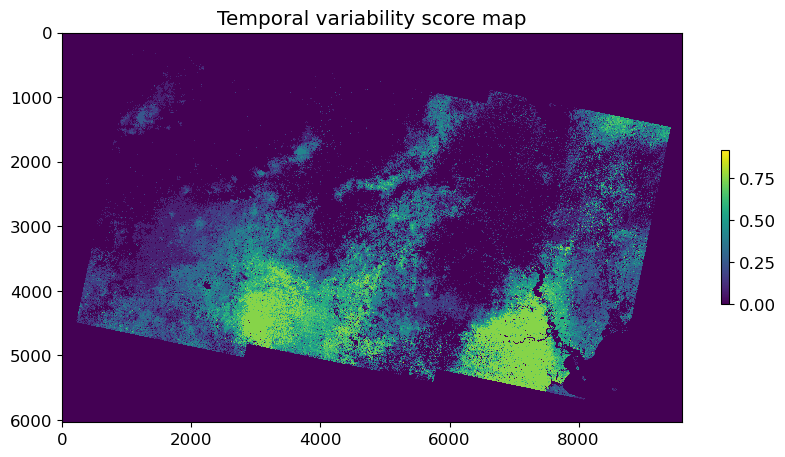

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(variability_scores, cmap='viridis', interpolation='none')
fig.colorbar(im, ax=ax, shrink=0.2)
ax.set_title('Temporal variability score map')

In [ ]:
thr_var_score = 0.7      # variability score threshold
mask_score_flag = True  # variability score mask

mask_var_score = variability_scores < thr_var_score     # selecting pixels with small temporal variability score

if mask_flag:
    for ii in range(n_dates):
        insar_displacement[ii,~mask] = np.nan  # applying mask

if mask_score_flag:
    for ii in range(n_dates):
        insar_displacement[ii,~mask_var_score] = np.nan  # applying mask of temporal variability score 

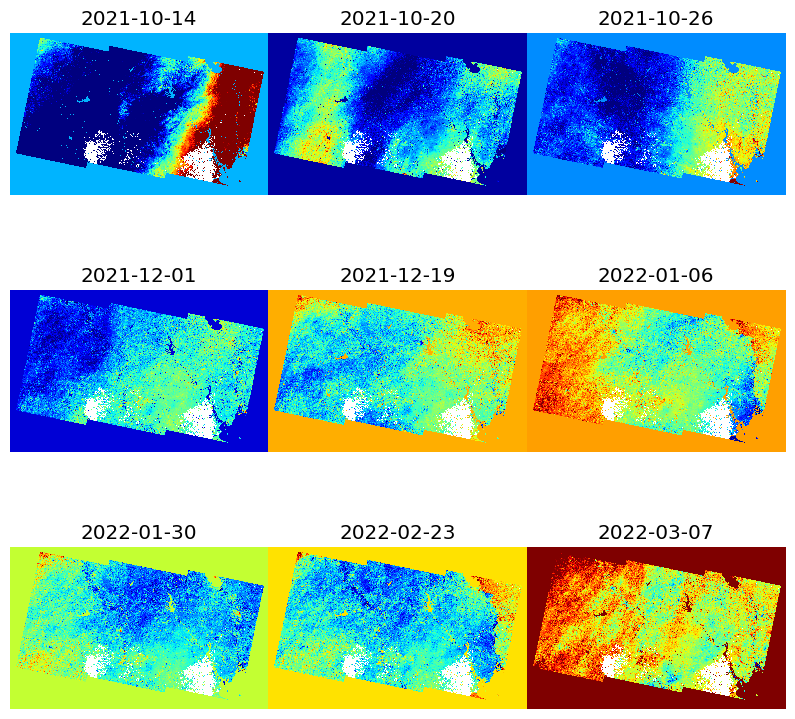

In [ ]:
# checking if variability masking worked
random_inds = np.random.choice(n_dates, num_plot, replace=False)
random_inds = sorted(random_inds)

fig, ax = plt.subplots(num_plot//3, 3,figsize=(10,10))
fig.subplots_adjust(hspace = .001, wspace=.001)

axs = ax.ravel()

for i in range(num_plot):
    axs[i].imshow(insar_displacement[random_inds[i],:,:], cmap='jet',vmin=-50,vmax=50, interpolation='none')     # unit: mm
    axs[i].axis('off')
    axs[i].set_title(ifgs_date[random_inds[i],0].strftime('%Y%m%d')+'-'+ifgs_date[random_inds[i],1].strftime('%Y%m%d'))

Preliminary summary: we have load all data we need for processing:
- `atr`: metadata, including incident angle, longitude and latitude step width, etc;
- `insar_displacement`: LOS measurement from InSAR;
- `insar_coherence`: coherence value of the interferograms:
- `ifgs_date`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_gnss_los'></a>
# Make GNSS LOS Measurements

<a id='transient_co_gnss'></a>
## Find Collocated GNSS Stations
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

Get space and time range for searching GNSS station:

In [ ]:
# set AOI
analysis_region = sites[site]['analysis_region'].split('"')[1].split()
analysis_region = [float(i) for i in analysis_region]
(S,N,W,E) = analysis_region
(OG_S,OG_N,OG_W,OG_E) = analysis_region
SNWE = [S,N,W,E]
OG_SNWE = [S,N,W,E]
S_yval, W_xval = ut.coordinate(atr).geo2radar(S, W)[:2]
N_yval, E_xval = ut.coordinate(atr).geo2radar(N, E)[:2]
# pre-query: convert UTM to lat/lon for query
if 'UTM_ZONE' in atr.keys():
    S, W = ut0.utm2latlon(atr, SNWE[2], SNWE[0])
    N, E = ut0.utm2latlon(atr, SNWE[3], SNWE[1])
    SNWE = (S, N, W, E)

In [ ]:
start_date_gnss = ifgs_date[0,0]
end_date_gnss = ifgs_date[-1,-1]

Search for collocated GNSS stations:

In [ ]:
os.chdir(mintpy_dir)
site_names, site_lats_wgs84, site_lons_wgs84 = gnss.search_gnss(SNWE=(S,N,W,E),
                                                    start_date=start_date_gnss.strftime('%Y%m%d'),
                                                    end_date=end_date_gnss.strftime('%Y%m%d'),
                                                    source=gnss_source)

# post-query: convert lat/lon to UTM for plotting
if 'UTM_ZONE' in atr.keys():
    site_lats, site_lons = ut0.latlon2utm(atr, site_lats_wgs84, site_lons_wgs84)
else:
    site_lats = site_lats_wgs84
    site_lons = site_lons_wgs84
os.chdir(work_dir)
site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

<a id='transient_gnss_los2'></a>
## Make GNSS LOS Measurements

In this step, the 3-D GNSS observations are projected into LOS direction. The InSAR observations are averaged 3 by 3 near the station positions.

**NOTE:** the number of pixels used in calculating the averaged phase values at the GPS location depends on the resolution of input data.

Get daily position solutions for GNSS stations:

In [ ]:
#os.chdir(mint_dir)
displacement = {}
gnss_time_series = {}
gnss_time_series_std = {}
bad_stn = {}  #stations to toss
pixel_radius = 1   #number of InSAR pixels to average for comparison with GNSS

for counter,stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = os.path.join(mintpy_dir,f'GNSS-{gnss_source}'))
    gps_obj.open()
        
    # count number of dates in time range
    gps_obj.read_displacement()
    dates = gps_obj.dates
    for i in range(insar_displacement.shape[0]):
        start_date = ifgs_date[i,0]
        end_date = ifgs_date[i,-1]
        
        range_days = (end_date - start_date).days
        gnss_count = np.histogram(dates, bins=[start_date,end_date])
        gnss_count = int(gnss_count[0])
        #print(gnss_count)

        # select GNSS stations based on data completeness, here we hope to select stations with data frequency of 1 day and no interruption
        if range_days == gnss_count-1:
        #if start_date in dates and end_date in dates:
            _, disp_gnss_time_series, disp_gnss_time_series_std, site_latlon = gps_obj.get_los_displacement(
                str(geom_file),
                start_date=start_date.strftime('%Y%m%d'),
                end_date=end_date.strftime('%Y%m%d'))[:4]
            # post-query: convert lat/lon to UTM
            stn_lat = site_latlon[0]
            stn_lon = site_latlon[1]
            y_value, x_value = ut.coordinate(atr).geo2radar(stn_lat, stn_lon)[:2]
            if 'UTM_ZONE' in atr.keys():
                stn_lat = float(site_lats_wgs84[i])
                stn_lon = float(site_lons_wgs84[i])

            #displacement from insar observation in the gnss station, averaged
            #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
            disp_insar = insar_displacement[i,
                                            y_value-pixel_radius:y_value+pixel_radius, 
                                            x_value-pixel_radius:x_value+pixel_radius]
            if np.isfinite(disp_insar).sum() == 0:
                break
            disp_insar = np.nanmean(disp_insar)

            disp_gnss_time_series = disp_gnss_time_series*1000 # convert unit from meter to mm
            disp_gnss_time_series_std = disp_gnss_time_series_std*1000
            gnss_time_series[(i,stn)] = disp_gnss_time_series
            gnss_time_series_std[(i,stn)] = disp_gnss_time_series_std
            displacement[(i,stn)] = list(site_latlon)
            disp_gnss = disp_gnss_time_series[-1] - disp_gnss_time_series[0]

            displacement[(i,stn)].append(disp_gnss)
            displacement[(i,stn)].append(disp_insar)
        else:
            try:
                bad_stn[i].append(stn)
            except:
                bad_stn[i] = [stn]
#os.chdir(cwd)

Do some data structure transformation:

In [ ]:
gnss_time_series = dict(sorted(gnss_time_series.items()))
gnss_time_series_std = dict(sorted(gnss_time_series_std.items()))
displacement = dict(sorted(displacement.items()))
bad_stn = dict(sorted(bad_stn.items()))

In [ ]:
gnss_time_series = pd.DataFrame.from_dict(gnss_time_series)
gnss_time_series_std = pd.DataFrame.from_dict(gnss_time_series_std)

In [ ]:
displacement = pd.DataFrame.from_dict(displacement,orient='index',
                                      columns=['lat','lon','gnss_disp','insar_disp'])
displacement.index = pd.MultiIndex.from_tuples(displacement.index,names=['ifg index','station'])

If there are less than 3 GNSS stations, don't conduct comparison:

In [ ]:
drop_index = []
for i in displacement.index.get_level_values(0).unique():
    if len(displacement.loc[i]) < 3:
        drop_index.append(i)
displacement=displacement.drop(drop_index)
# ifgs_date after drop for approach 1
ifgs_date_ap1=np.delete(ifgs_date,drop_index,axis=0)

All data needed for approach 1:

In [ ]:
displacement

**NOTE:** 
- A more general criterion is needed for GNSS station selection. Here the stations with uninterrupted data are selected while, in Secular Requirement Validation, stations are selected by data completeness and standard variation.

<a id='transient_gnss_insar'></a>
## Make GNSS and InSAR Relative Displacements

Here we randomly select one reference site and make both the GNSS and InSAR measurements relative to that reference to remove a constant offset.

In [ ]:
# reference GNSS stations to GNSS reference site
for i in displacement.index.get_level_values(0).unique():
    gps_ref_site_name = random.choice(displacement.loc[i].index.unique())
    displacement.loc[i,'gnss_disp'] = displacement.loc[i,'gnss_disp'].values - displacement.loc[(i,gps_ref_site_name),'gnss_disp']
    displacement.loc[i,'insar_disp'] = displacement.loc[i,'insar_disp'].values - displacement.loc[(i,gps_ref_site_name),'insar_disp']
    # post-query: convert lat/lon to UTM
    ref_x_value = displacement.loc[(i,gps_ref_site_name),'lon']
    ref_y_value = displacement.loc[(i,gps_ref_site_name),'lat']
    ref_y_value, ref_x_value = ut.coordinate(atr).geo2radar(ref_y_value, ref_x_value)[:2]

    ref_disp_insar = insar_displacement[i,
                                        ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                        ref_x_value-pixel_radius:ref_x_value+1+pixel_radius]
    ref_disp_insar = np.nanmean(ref_disp_insar)
    insar_displacement[i] -= ref_disp_insar
    test_disp_insar = np.nanmean(insar_displacement[i,
                                        ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                        ref_x_value-pixel_radius:ref_x_value+1+pixel_radius])

Plot GNSS stations on InSAR displacement fields

In [ ]:
cmap = copy.copy(plt.get_cmap('RdBu'))
#cmap.set_bad(color='black')
vmin, vmax = np.nanmin(insar_displacement), np.nanmax(insar_displacement)
for i in displacement.index.get_level_values(0).unique():
    fig, ax = plt.subplots(figsize=[18, 5.5])
    ifg_iter = insar_displacement[i,
                            N_yval:S_yval, 
                            W_xval:E_xval]
    img1 = ax.imshow(ifg_iter, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
    ax.set_title(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))
    cbar1 = fig.colorbar(img1, ax=ax)
    cbar1.set_label('LOS displacement [mm]')

    for stn in displacement.loc[i].index:
        lon,lat = displacement.loc[(i,stn),'lon'],displacement.loc[(i,stn),'lat']

        color = cmap((displacement.loc[(i,stn),'gnss_disp']-vmin)/(vmax-vmin))
        ax.scatter(lon,lat,s=8**2,color=color,edgecolors='k')
        ax.annotate(stn,(lon,lat),color='black')

GNSS station vs InSAR displacement histograms

In [ ]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    disp_range = (min([*displacement.loc[i]['insar_disp'],*displacement.loc[i]['gnss_disp']]),
                  max([*displacement.loc[i]['insar_disp'],*displacement.loc[i]['gnss_disp']]))
    plt.hist(displacement.loc[i]['insar_disp'],bins=100,range=disp_range,color = "green",label='D_InSAR')
    plt.hist(displacement.loc[i]['gnss_disp'],bins=100,range=disp_range,color="orange",label='D_GNSS', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Displacement spread')
    plt.show()

<a id='transient_validation1'></a>
# NISAR Validation Approach 1: GNSS-InSAR Direct Comparison

<a id='transient_pair1'></a>
## Pair up GNSS stations and make measurement residuals

We first pair up all GNSS stations and compare the relative measurement from both GNSS and INSAR. 

In [ ]:
insar_disp = {}
gnss_disp = {}
ddiff_dist = {}
ddiff_disp = {}
abs_ddiff_disp = {}
for i in displacement.index.get_level_values(0).unique():
    displacement_i = displacement.loc[i]
    insar_disp_i = []
    gnss_disp_i = []
    ddiff_dist_i = []
    ddiff_disp_i = []

    for sta1 in displacement_i.index:
        for sta2 in displacement_i.index:
            if sta2 == sta1:
                break
            insar_disp_i.append(displacement_i.loc[sta1,'insar_disp']-displacement_i.loc[sta2,'insar_disp'])
            gnss_disp_i.append(displacement_i.loc[sta1,'gnss_disp']-displacement_i.loc[sta2,'gnss_disp'])
            ddiff_disp_i.append(gnss_disp_i[-1]-insar_disp_i[-1])
            g = pyproj.Geod(ellps="WGS84")
            _,_,distance = g.inv(displacement_i.loc[sta1,'lon'],displacement_i.loc[sta1,'lat'],
                                 displacement_i.loc[sta2,'lon'],displacement_i.loc[sta2,'lat'])
            distance = distance/1000 # convert unit from m to km
            ddiff_dist_i.append(distance)
    insar_disp[i]=np.array(insar_disp_i)
    gnss_disp[i]=np.array(gnss_disp_i)
    ddiff_dist[i]=np.array(ddiff_dist_i)
    ddiff_disp[i]=np.array(ddiff_disp_i)
    abs_ddiff_disp[i]=abs(np.array(ddiff_disp_i))

Plot to compare displacement from GNSS and InSAR:

In [ ]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    disp_range = (min([*insar_disp[i],*gnss_disp[i]]),max([*insar_disp[i],*gnss_disp[i]]))
    plt.hist(insar_disp[i],bins=100,range=disp_range,color = "green",label='D_InSAR')
    plt.hist(gnss_disp[i],bins=100,range=disp_range,color="orange",label='D_GNSS', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title(f"Displacements \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')} \n Number of station pairs used: {len(insar_disp[i])}")
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Number of Station Pairs')
    plt.show()

Plot Displacement Residuals Distribution:

In [ ]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    plt.hist(ddiff_disp[i],bins = 100, color="darkblue",linewidth=1,label='D_gnss - D_InSAR')
    plt.legend(loc='upper right')
    plt.title(f"Residuals \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')} \n Number of stations pairs used: {len(ddiff_disp[i])}")
    plt.xlabel('Displacement Residual (mm)')
    plt.ylabel('N Stations')
    plt.show()

Plot Absolute Displacement Residuals As a Function of Distance:

In [ ]:
for i in displacement.index.get_level_values(0).unique():
    dist_th = np.linspace(min(ddiff_dist[i]),max(ddiff_dist[i]),100)
    acpt_error = 3*(1+np.sqrt(dist_th))
    plt.figure(figsize=(11,7))
    plt.scatter(ddiff_dist[i],abs_ddiff_disp[i],s=1)
    plt.plot(dist_th, acpt_error, 'r')
    plt.xlabel("Distance (km)")
    plt.ylabel("Amplitude of Displacement Residuals (mm)")
    plt.title(f"Residuals \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')} \n Number of stations pairs used: {len(ddiff_dist[i])}")
    plt.legend(["Mission Reqiurement","Measuement"])
    #plt.xlim(0,5)
    plt.show()

In [ ]:
ddiff_dist_ap1 = list(ddiff_dist.values())
abs_ddiff_disp_ap1 = list(abs_ddiff_disp.values())

We have got all needed data for approach 1:
- `ddiff_dist_ap1`: distance of GNSS pairs,
- `abs_ddiff_disp_ap1`: absolute value of measurement redisuals,
- `ifgs_date_ap1`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_bin1'></a>
## Validate the requirement based on binned measurement residuals

In [ ]:
n_ifgs = len(ddiff_dist_ap1)

Bin all measurement residuals to check if they pass the requirements or not:

In [ ]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [ ]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
for i in range(n_ifgs):
    inds = np.digitize(ddiff_dist_ap1[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(ddiff_dist_ap1[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = abs_ddiff_disp_ap1[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [ ]:
ratio = n_pass/n_all
thresthod = 0.683 
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result1'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [ ]:
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date_ap1)):
    index.append(ifgs_date_ap1[i,0].strftime('%Y%m%d')+'-'+ifgs_date_ap1[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

Number of data points in each bin:

In [ ]:
n_all_pd

Number of data points that below the curve:

In [ ]:
n_pass_pd

Percentage of pass:

In [ ]:
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

<a id='transient_conclusion1'></a>
## Conclusion

In [ ]:
percentage = np.count_nonzero(ratio_pd['total']>thresthod)/n_ifgs
print(f"Percentage of interferograms passes the requirement: {percentage}")
if percentage >= 0.70:
    print('The interferogram stack passes the requirement.')
else:
    print('The interferogram stack fails the requirement.')

<div class="alert alert-warning">
Approach 1 final result for CentralValleyA144: around 79% of interferograms passes the requirement.
</div>

<a id='transient_validation2'></a>
# NISAR Validation Approach 2: Noise Level Validation

In this validation (Approach #2), we evaluate the estimated secular deformation rate (Requirements 658) or co-seismic displacement (Requirement 660) from time series processing or the individual unwrapped interferogram (Requirement 663) over selected cal/val areas with negligible deformation. Any estimated deformation should thus be treated as noise and our goal is to evaluate the significance of this noise. In general, noise in the modeled displacement or the unwrapped interferogram is anisotropic, but here we neglect this anisotropy. Also, we assume the noise is stationary.

We first randomly sample measurements and pair up sampled pixel measurements. For each pixel-pair, the difference of their measurement becomes:
$$d\left(r\right)=|(f\left(x\right)-f\left(x-r\right))|$$
Estimates of $d(r)$ from all pairs are binned according to the distance r. In each bin, $d(r)$ is assumed to be a normal distribution.

**Note:** Now we simply assume there is no deformation in this study area and time interval. But in fact, it is hard to find a enough large area without any deformation. An more realistic solution is to apply a mask to mask out deformed regions.

In [ ]:
n_ifgs = insar_displacement.shape[0]

Mask Pixels with Low Coherence (optional)

In [ ]:
#insar_displacement[insar_coherence <0.6] = np.nan

Plot the coherence and InSAR measurements:

In [ ]:
cmap = plt.get_cmap('gray')

for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    coh_iter = insar_coherence[i,
                            N_yval:S_yval, 
                            W_xval:E_xval]
    img1 = ax.imshow(coh_iter,cmap=cmap, interpolation='nearest',extent=(W, E, S, N))
    ax.set_title(f"Coherence \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    cbar1 = fig.colorbar(img1, ax=ax)
    cbar1.set_label('coherence')

In [ ]:
cmap = plt.get_cmap('RdBu')
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    ifg_iter = insar_displacement[i,
                            N_yval:S_yval, 
                            W_xval:E_xval]
    img1 = ax.imshow(ifg_iter, cmap=cmap, interpolation='nearest', extent=(W, E, S, N))
    ax.set_title(f"Interferogram \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    cbar1 = fig.colorbar(img1, ax=ax)
    cbar1.set_label('LOS displacement [mm]')

<a id='transient_pair2'></a>
## Randomly sample pixels and pair them up

Calculate the coordinate for every pixel:

In [ ]:
X0,Y0 = load_geo(atr)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

For each interferogram, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

In [ ]:
dist = []; rel_measure = []
for i in range(n_ifgs):
    dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,insar_displacement[i],num_samples=1000000)
    dist.append(dist_i)
    rel_measure.append(rel_measure_i)

Show the statistical property of selected pixel pairs:

In [ ]:
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(dist[i], bins=100)
    ax.set_title(f"Histogram of distance \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Distance ($km$)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0,50)

In [ ]:
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(rel_measure[i], bins=100)
    ax.set_title(f"Histogram of Relative Measurement \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Relative Measurement ($mm$)')
    ax.set_ylabel('Frequency')

In [ ]:
dist_th = np.linspace(0,50,100)
rqmt = 3*(1+np.sqrt(dist_th))
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    ax.plot(dist_th, rqmt, 'r')
    ax.scatter(dist[i], rel_measure[i], s=1, alpha=0.25)
    ax.set_title(f"Comparation between Relative Measurement and Requirement Curve \n Date range {ifgs_date[i,0].strftime('%Y%m%d')}-{ifgs_date[i,1].strftime('%Y%m%d')}")
    ax.set_ylabel(r'Relative Measurement ($mm$)')
    ax.set_xlabel('Distance (km)')
    ax.set_xlim(0,50)

We have got data used of approach 2:
- `dist`: distance of pixel pairs,
- `rel_measure`: relative measurement of pixel pairs,
- `ifgs_date`: list of date pairs of two SAR images that form a interferogram.

<a id='transient_bin2'></a>
## Validate the requirement based on binned measurement residuals

In [ ]:
n_ifgs = len(dist)

Bin all measurement residuals to check if they pass the requirements or not:

In [ ]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [ ]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
#ratio = np.empty([n_ifgs,n_bins+1]) # ratio
# the final column is the ratio as a whole
for i in range(n_ifgs):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [ ]:
ratio = n_pass/n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))
thresthod = 0.683
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result2'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [ ]:
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns+['mean'],index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns+['mean'],index=index)

Number of data points in each bin:

In [ ]:
n_all_pd

Number of data points that below the curve:

In [ ]:
n_pass_pd

Ratio of pass:

In [ ]:
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

<a id='transient_conclusion2'></a>
## Conclusion

Compared with percentage of total passed pairs, the mean value of percentage of passed pairs in all bin is a better indicator since it gives all bins same weight. 

In [ ]:
percentage = np.count_nonzero(ratio_pd['mean']>thresthod)/n_ifgs

In [ ]:
print(f"Percentage of interferograms passes the requirement (70%): {percentage}.")
if percentage >= 0.70:
    print('The interferogram stack passes the requirement.')
else:
    print('The interferogram stack fails the requirement.')

<div class="alert alert-warning">
Approach 2 final result for CentralValleyA144: 100% of interferograms passes the requirement.
</div>

<a id='transient_appendix'></a>
# Appendix: GNSS Position Plots

GNSS vs InSAR scatter plots

In [ ]:
gps_ref_site_name = sites[site]['gps_ref_site_name']
for stn in site_names:
    date_list = []
    gnss_series = []
    insar_series = []
    for i in range(n_ifgs):
        # catch cases where GPS site has been filtered out
        try:
            ref_gnss_dat = displacement.loc[(i,gps_ref_site_name),'gnss_disp']
            ref_insar_dat = displacement.loc[(i,gps_ref_site_name),'insar_disp']
            gnss_series.append(displacement.loc[(i,str(stn)),'gnss_disp'] - ref_gnss_dat)
            insar_series.append(displacement.loc[(i,str(stn)),'insar_disp'] - ref_insar_dat)
            date_list.append(ifgs_date[i,1].strftime('%Y%m%d'))
        except KeyError:
            pass

    # only plot for cases where GPS site has not been filtered out
    if date_list != [] and gnss_series != [] and insar_series != []:
        dt_date_list = [dt.strptime(date, '%Y%m%d').strftime('%Y-%m-%d') for date in date_list]
        # plot station TS
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.set_title(f"station name: {stn}")
        ax.scatter(dt_date_list, insar_series, c='#ff7f0e', label="InSAR")
        ax.scatter(dt_date_list, gnss_series, c='#1f77b4', label="GNSS", alpha=0.7)
        ax.set_xlabel('Time')
        ax.set_ylabel('Relative position in LOS direction (mm)')
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.legend()
        plt.show()